# HOUSE_PRICE

在参考之前的https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard?scriptVersionId=1955054文档后，个人的解决方案如下：

## 整体分为：
* 查看数据
* 特征工程
* 构建模型及预测

### 查看数据
* 数据类型
* 缺失值
* 异常值检测
* 预测值正态化校验
* 相关性检测

![](./数据查看.png)

#### 查看数据

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mplt
#不显示warn信息
import warnings
import missingno as msno
from sklearn import preprocessing
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [2]:
newline = '\n'
forward_color = "\033[1;31;40m"
backward_color = "\033[0m"

In [3]:
def show_special_text(text):
    return forward_color+str(text)+backward_color

In [4]:
def glance_data(data):
    print('-----查看数据的前五行----')
    print(data.head(),newline)
    print('-----查看数据是否有缺失值，类型，记录的总数----')
    data.info()
    print(newline)
    print('-----查看数据缺失值情况--------')
    print(data.isnull().sum())

In [5]:
#单个列数据的详情
def see_column_detail(data,column):
    print('------------',column,'列详情---------------')
    #查看该列的数据类型
    print(column,'数据类型是：',show_special_text(data[column].dtype))

    #查看该列共有多少种取值个数
    cols_possible_value_count = data[column].value_counts().count()
    print(column,'共有',show_special_text(cols_possible_value_count),'种取值',newline)

    print(column,'每个取值有分布情况-----')
    if cols_possible_value_count <= 15:
        print(data[column].value_counts())
    else:
        print(data[column].value_counts().head(15))
    print(newline)
    print(column,'共有',show_special_text(data[column].isnull().sum()),'个缺失值')
    print(newline)

In [6]:
#指定n列数据的查看，默认展示前100列的情况
def see_columns_detail(data,columns=[]):
    i = 0
    if len(columns)==0:
        columns = data.columns
    if len(columns) <= 100:
        for column in columns:
            see_column_detail(data,column)
    else:
        if i <= 100:
            for column in columns:
                see_column_detail(data,column)
                i += 1

##### 柱状图查看每列的分布

In [38]:
def build_bar_graph(x_feature,y_data,x_label,y_label,title):
    _,ax = plt.subplots()
    ax.bar(range(len(x_feature)),y_data,color='#539caf', align = 'center')#此处不能直接使用x_feature,应用数字类型len(x_feature)
#     ax.errorbar(range(len(x_feature)),y_mean,yerr=error_bar_std,color = 'darkred', ls = 'none', lw = 5)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    plt.setp(ax,xticks=range(len(x_feature)),xticklabels=x_feature)

#### 查看数据缺失情况
* 图形化展示
* 表格展示

In [7]:
# 通过第三方库missingon展示缺失值情况：
def bulid_graph_missing_data(train):
    msno.matrix(train,figsize=(12,5))

In [8]:
# 显示每列缺失值的具体比例情况：
def missing_data_percent(train):
    total = train.isnull().sum().sort_values(ascending=False)
    percent = (train.isnull().sum()/train.shape[0]).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(20))

#### 异常值检测
* 箱线图
* 多元统计分析

##### 箱线图

In [9]:
def build_box_plot(x_data, y_data, x_label, y_label, title):
    _, ax = plt.subplots()
    # 设置样式
    ax.boxplot(y_data
               # 箱子是否颜色填充
               , patch_artist = True
               # 中位数线颜色
               , medianprops = {'color': 'r'}
               # 箱子颜色设置，color：边框颜色，facecolor：填充颜色
               , boxprops = {'color': 'r', 'facecolor': 'b'}
               # 猫须颜色whisker
               , whiskerprops = {'color': 'b'}
               # 猫须界限颜色whisker cap
               , capprops = {'color': 'b'}
               , sym='ro')
               

    # 箱图与x_data保持一致
    ax.set_xticklabels(x_data)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

##### 多元统计分析——步骤
* 每个变量的点图
* 每对变量的散布图
* 检查标准化值中的最大最小值
* 计算广义平方距离

In [10]:
#计算z-score值
def z_score(train):
    scaler = preprocessing.StandardScaler().fit(train)
    print(scaler.transform(train))

In [11]:
#画每对变量的分布图
def distrub_graph(df,cols=[]):
    if len(cols)==0:
        cols = df.columns
    sns.set()
#     cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
    sns.pairplot(df[cols], size = 2.5)
    plt.show();

##### 计算马氏距离(广义平方距离)
参考文章https://my.oschina.net/dfsj66011/blog/793392

In [12]:
def ma_dis(df,n_outliers):
    m_dist_order =  Series([float(distance.mahalanobis(hw.iloc[i], hw.mean(), np.mat(hw.cov().as_matrix()).I) ** 2)
       for i in range(len(hw))]).sort_values(ascending=False).index.tolist()
    is_outlier = [False, ] * 16
    for i in range(n_outliers):
        is_outlier[m_dist_order[i]] = True
    color = ['g', 'r']
    pch = [1 if is_outlier[i] == True else 0 for i in range(len(is_outlier))]
    cValue = [color[is_outlier[i]] for i in range(len(is_outlier))]
    fig = plt.figure()
    plt.title('Scatter Plot')
    plt.xlabel('Height_cm')
    plt.ylabel('Weight_kg')
    plt.scatter(hw['Height_cm'], hw['Weight_kg'], s=40, c=cValue)
    plt.show()

#### 查看预测值分布
* 绘制分布图
* 绘制Q-Q图
* 计算峰度/偏峰值

In [13]:
def build_normal_graph(df,pridict_val,y_lable,title):
    sns.distplot(df[pridict_val] , fit=norm)
    #
    print('------------偏斜值/峰度------------')
    print(newline)
    print("Skewness: %f" % df[pridict_val].skew())
    print("Kurtosis: %f" % df[pridict_val].kurt())
    print(newline)
    (mu, sigma) = norm.fit(df[pridict_val])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel(y_lable)
    plt.title(title)
    print('Q-Q图'+newline)
    fig = plt.figure()
    res = stats.probplot(df[pridict_val], plot=plt)
    plt.show()

#### 热力图

In [14]:
def all_cols_heatmap_graph(df):
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True)

In [25]:
def n_heatmap_graph(df,k= 10):
    corrmat = df.corr()
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

### 读取train_data分别做上述处理

In [16]:
train = pd.read_csv('./data/train.csv')

In [17]:
glance_data(train)

-----查看数据的前五行----
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0 

In [18]:
see_columns_detail(train)

------------ Id 列详情---------------
Id 数据类型是： int64
Id 共有 1460 种取值 

Id 每个取值有分布情况-----
1460    1
479     1
481     1
482     1
483     1
484     1
485     1
486     1
487     1
488     1
489     1
490     1
491     1
492     1
493     1
Name: Id, dtype: int64


Id 共有 0 个缺失值


------------ MSSubClass 列详情---------------
MSSubClass 数据类型是： int64
MSSubClass 共有 15 种取值 

MSSubClass 每个取值有分布情况-----
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64


MSSubClass 共有 0 个缺失值


------------ MSZoning 列详情---------------
MSZoning 数据类型是： object
MSZoning 共有 5 种取值 

MSZoning 每个取值有分布情况-----
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


MSZoning 共有 0 个缺失值


------------ LotFrontage 列详情---------------
LotFrontage 数据类型是： float64
LotFrontage 共有 110 种取值 

LotFrontage 每个取值有分布情况-----
60.0    143
70.0     70


BsmtFinType2 数据类型是： object
BsmtFinType2 共有 6 种取值 

BsmtFinType2 每个取值有分布情况-----
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


BsmtFinType2 共有 38 个缺失值


------------ BsmtFinSF2 列详情---------------
BsmtFinSF2 数据类型是： int64
BsmtFinSF2 共有 144 种取值 

BsmtFinSF2 每个取值有分布情况-----
0      1293
180       5
374       3
551       2
93        2
468       2
147       2
480       2
539       2
712       2
117       2
279       2
96        2
391       2
287       2
Name: BsmtFinSF2, dtype: int64


BsmtFinSF2 共有 0 个缺失值


------------ BsmtUnfSF 列详情---------------
BsmtUnfSF 数据类型是： int64
BsmtUnfSF 共有 780 种取值 

BsmtUnfSF 每个取值有分布情况-----
0      118
728      9
384      8
572      7
600      7
300      7
440      6
625      6
280      6
672      6
270      6
162      5
108      5
490      5
390      5
Name: BsmtUnfSF, dtype: int64


BsmtUnfSF 共有 0 个缺失值


------------ TotalBsmtSF 列详情---------------
TotalBsmtSF 数据类型是： int64
TotalBsmtSF 共有 721 种取值 

TotalBsmt

------------ SaleCondition 列详情---------------
SaleCondition 数据类型是： object
SaleCondition 共有 6 种取值 

SaleCondition 每个取值有分布情况-----
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


SaleCondition 共有 0 个缺失值


------------ SalePrice 列详情---------------
SalePrice 数据类型是： int64
SalePrice 共有 663 种取值 

SalePrice 每个取值有分布情况-----
140000    20
135000    17
145000    14
155000    14
190000    13
110000    13
160000    12
115000    12
139000    11
130000    11
125000    10
143000    10
185000    10
180000    10
144000    10
Name: SalePrice, dtype: int64


SalePrice 共有 0 个缺失值




C:\Users\caiqiang\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


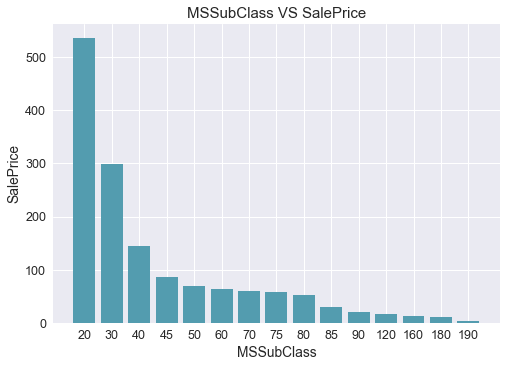

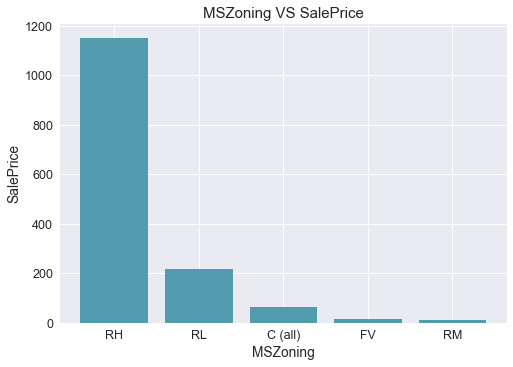

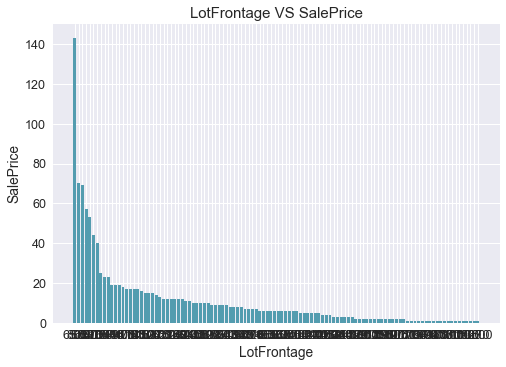

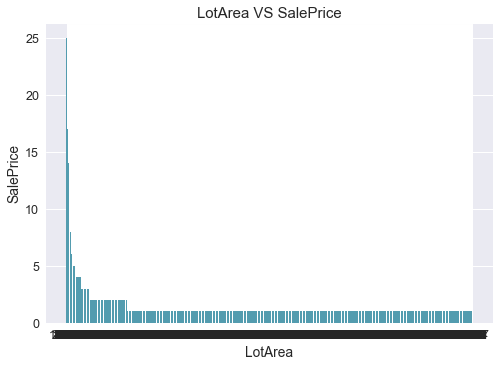

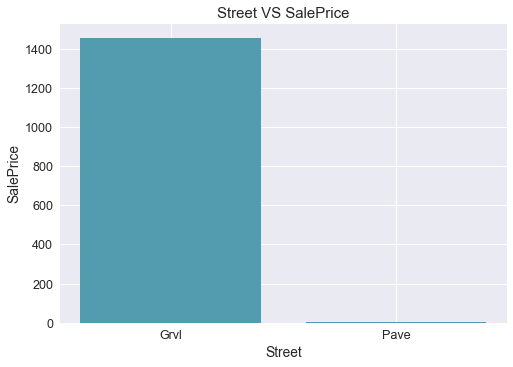

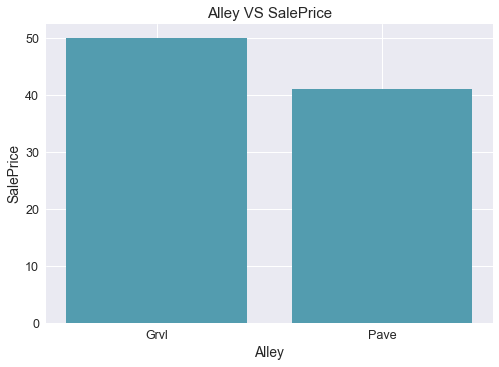

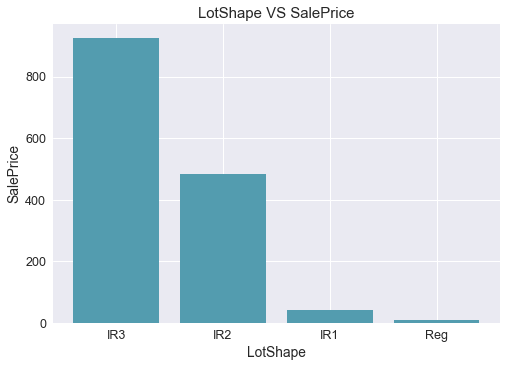

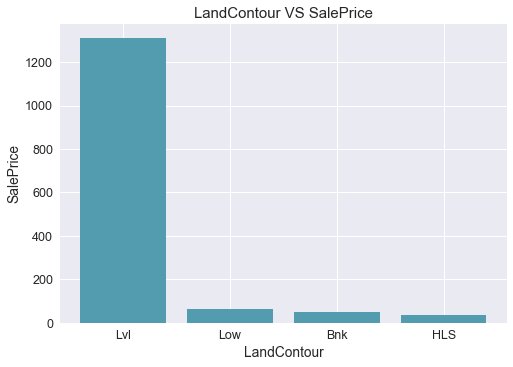

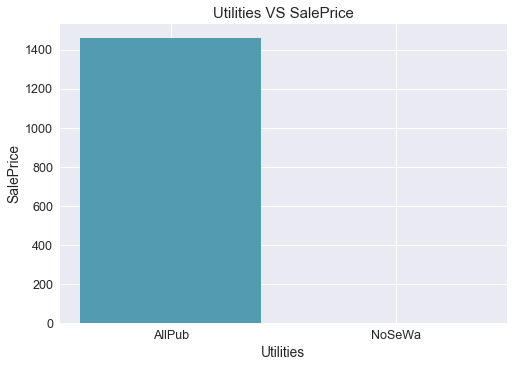

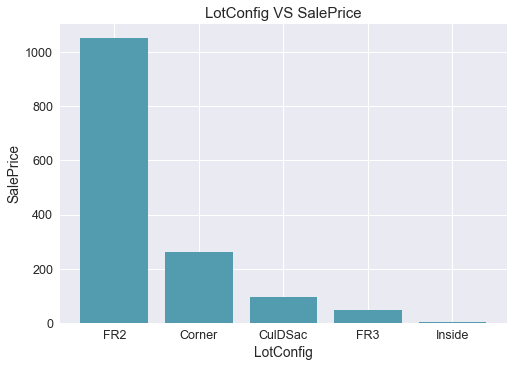

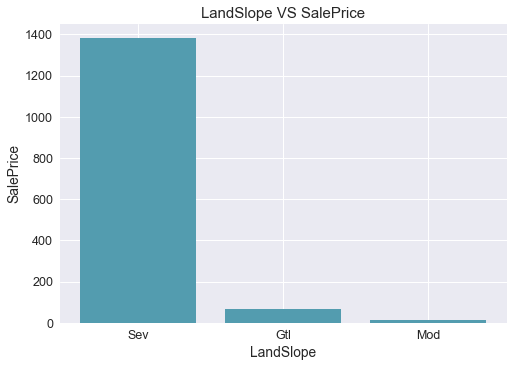

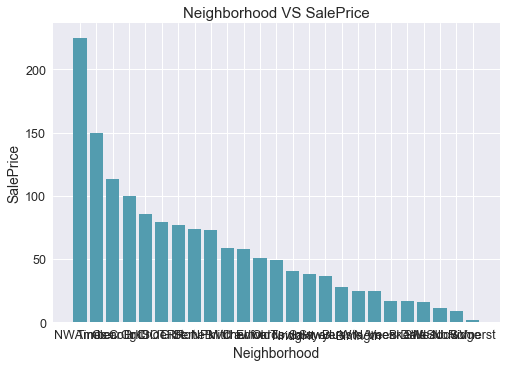

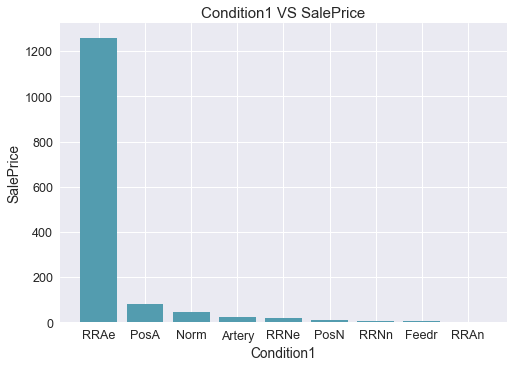

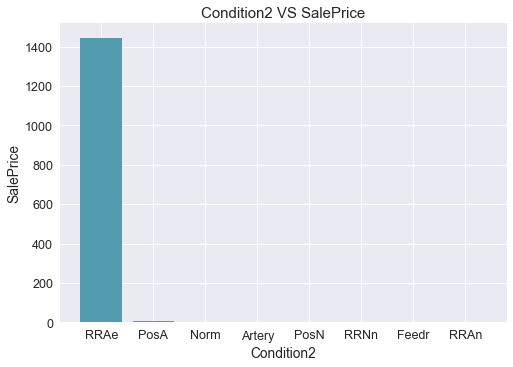

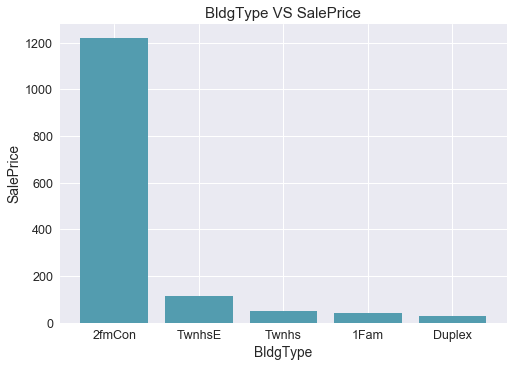

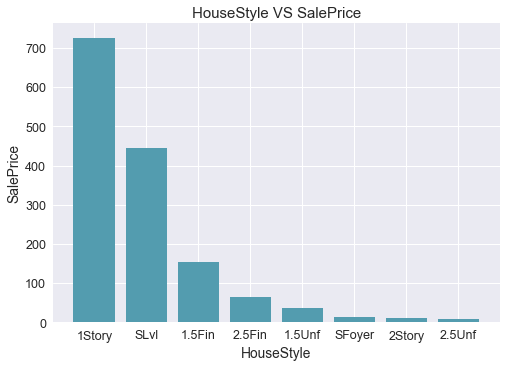

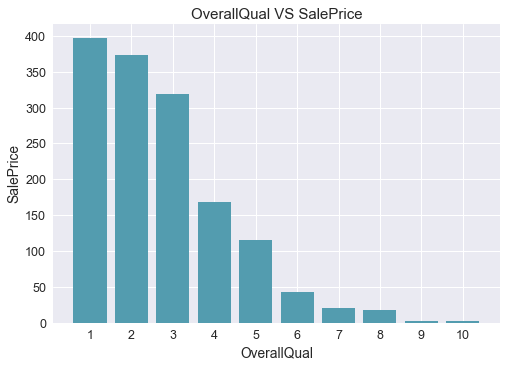

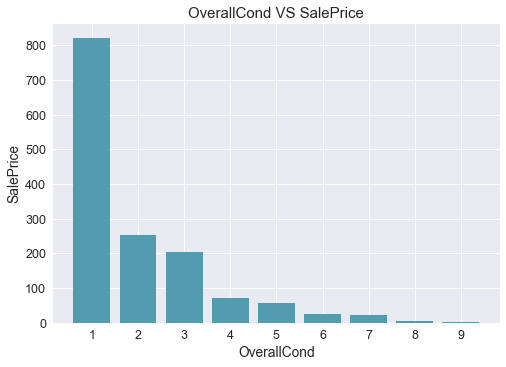

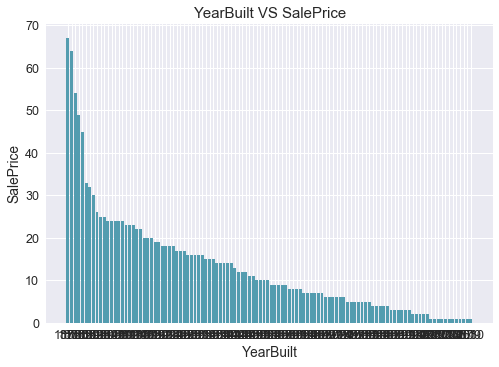

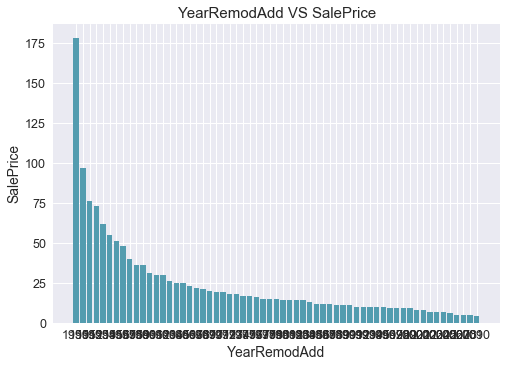

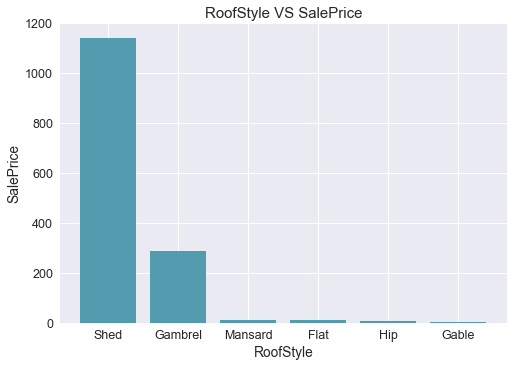

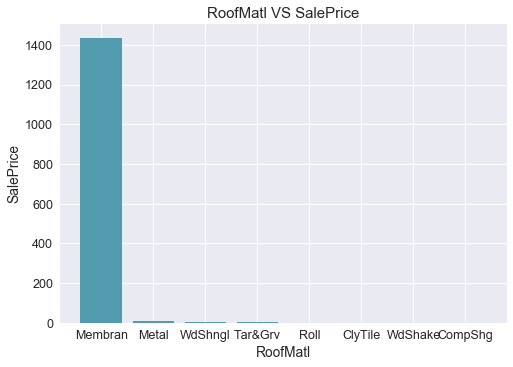

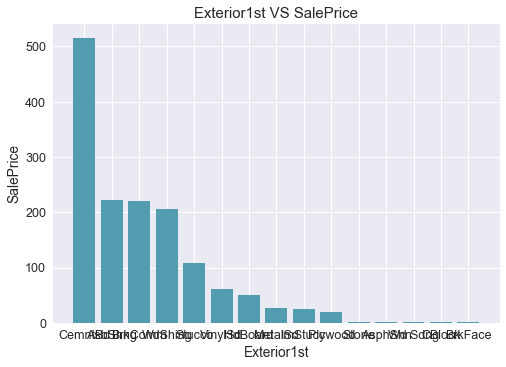

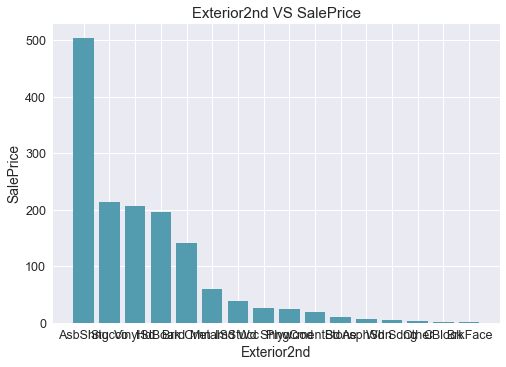

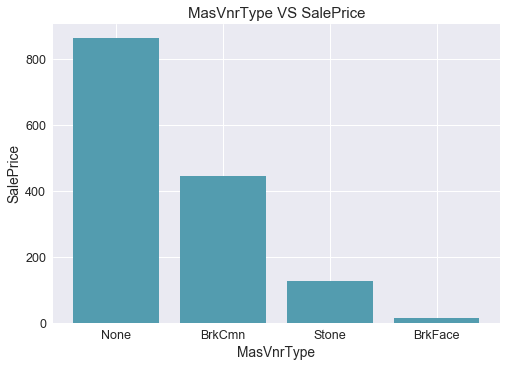

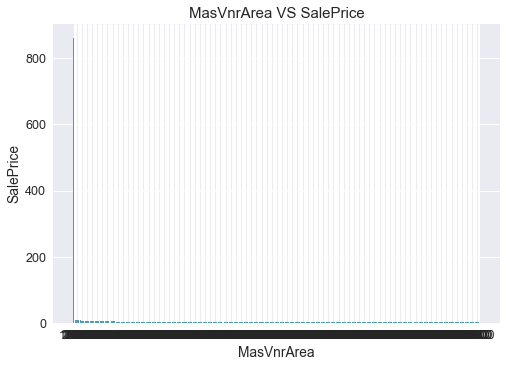

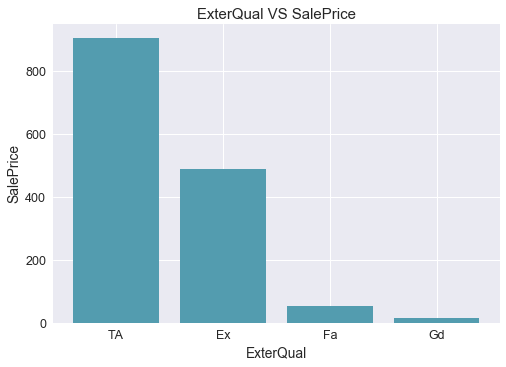

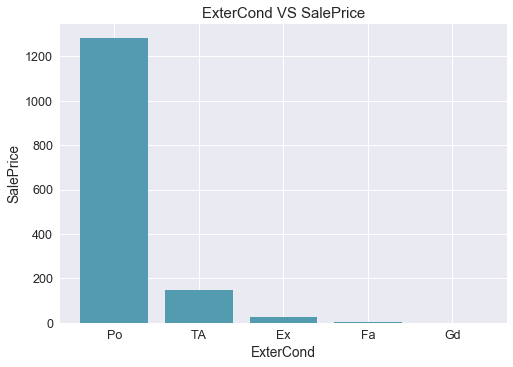

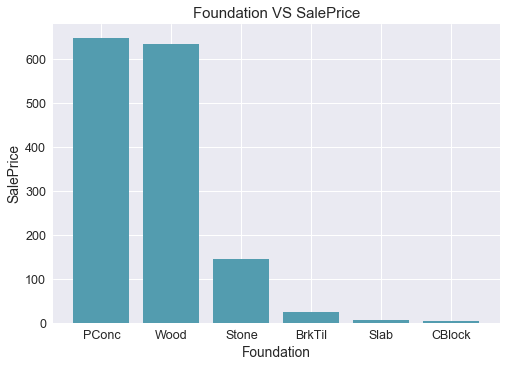

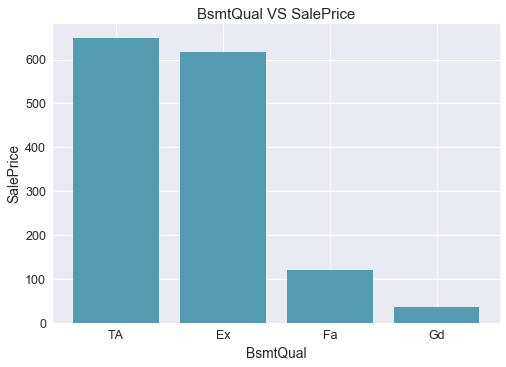

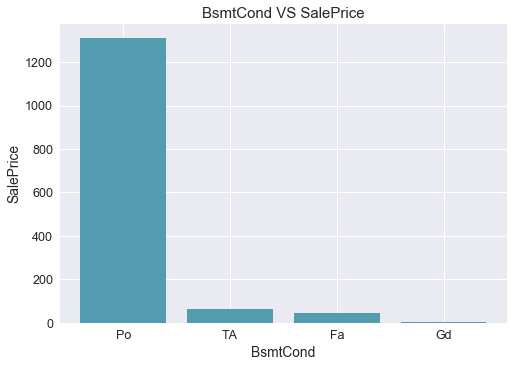

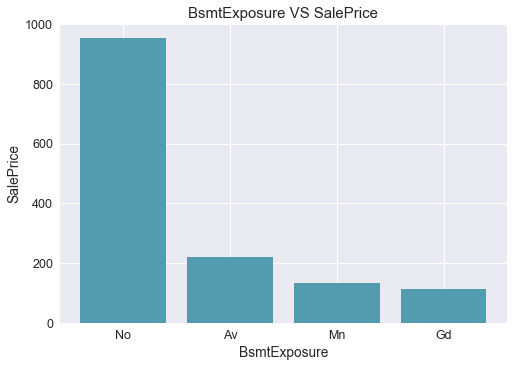

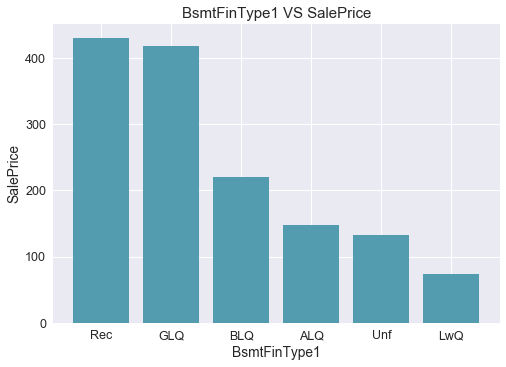

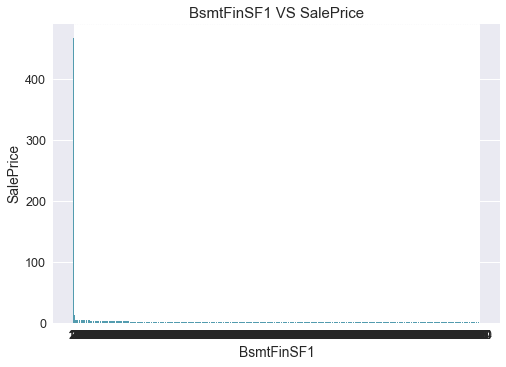

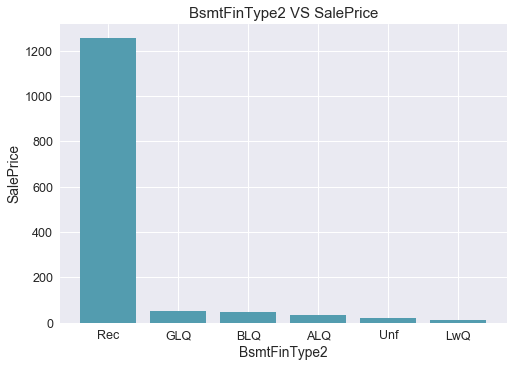

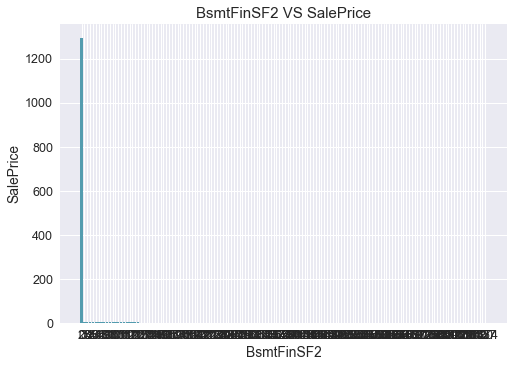

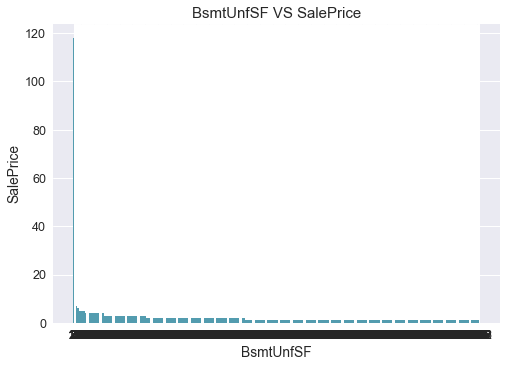

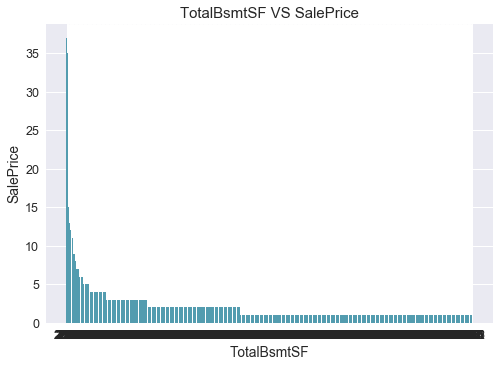

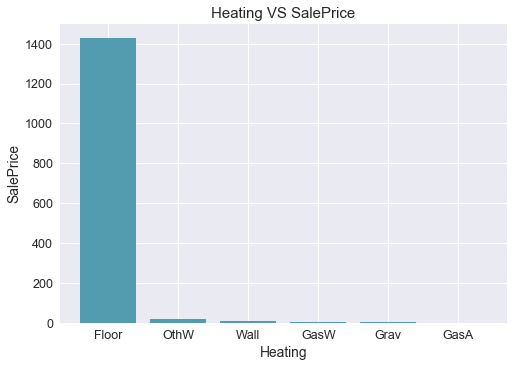

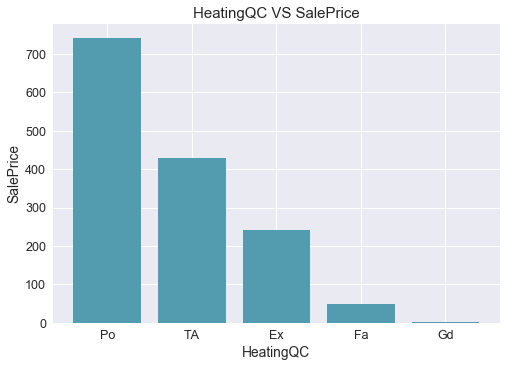

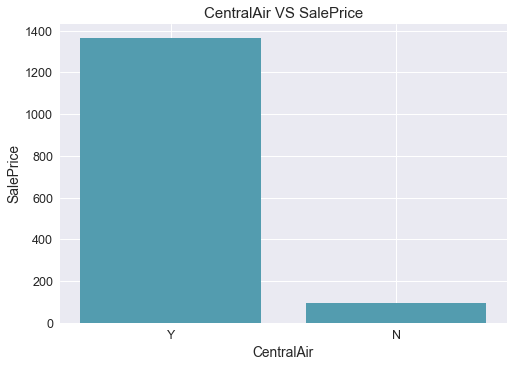

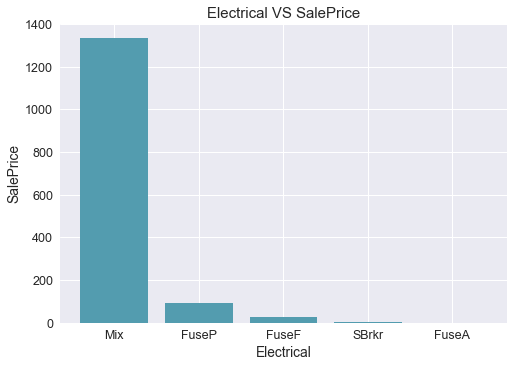

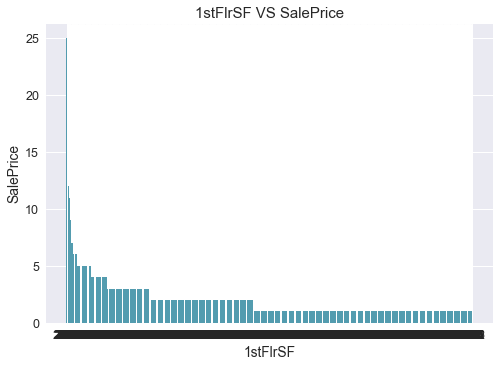

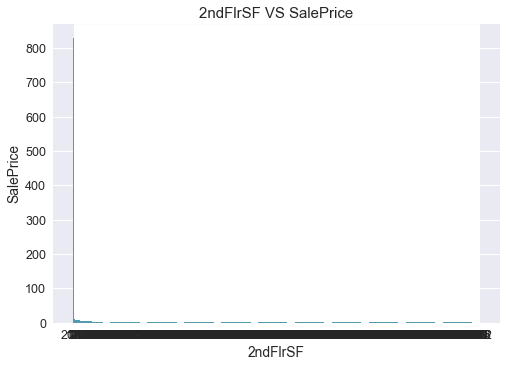

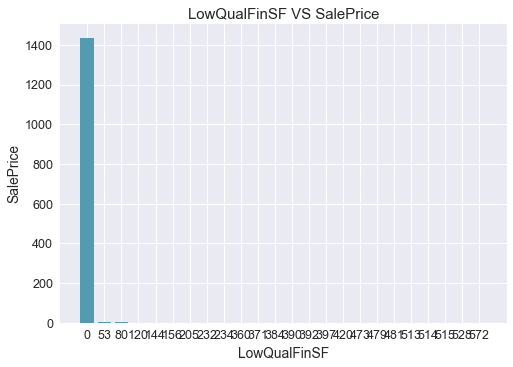

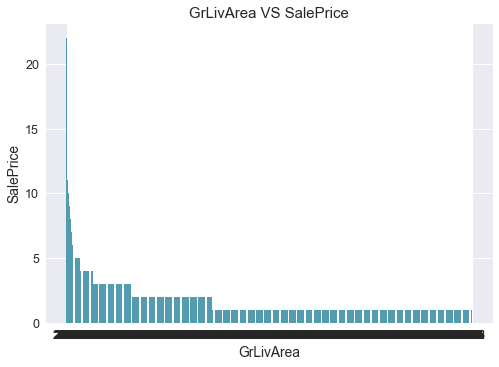

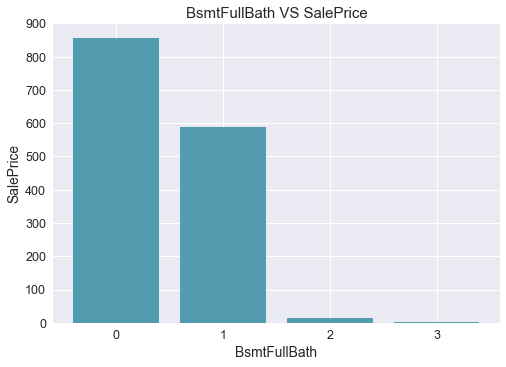

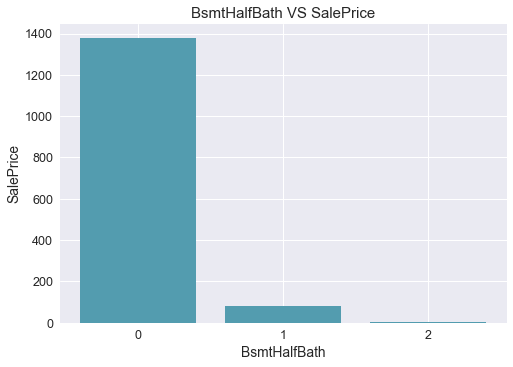

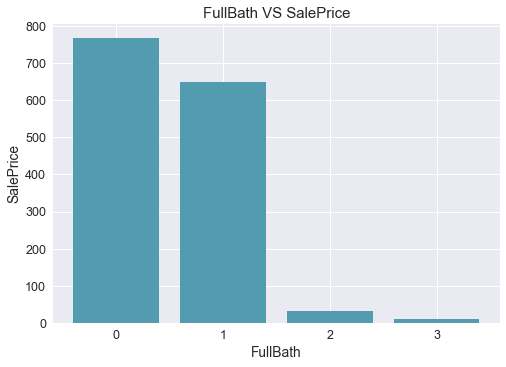

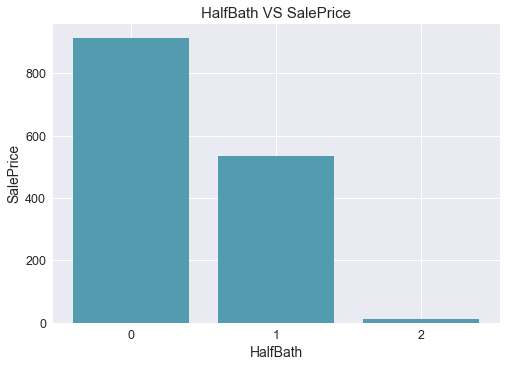

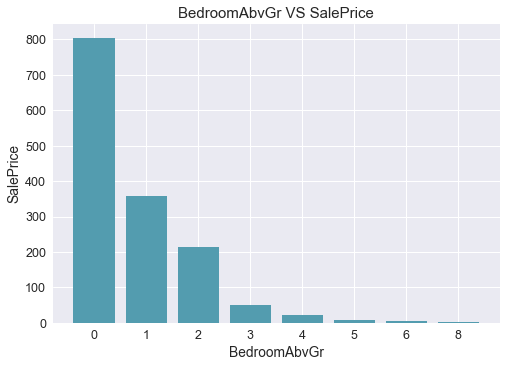

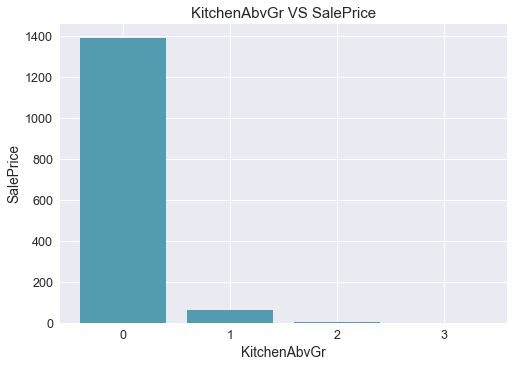

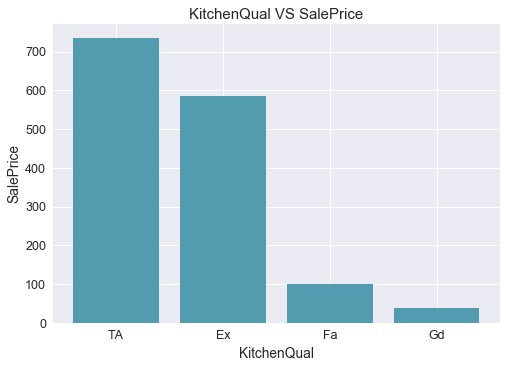

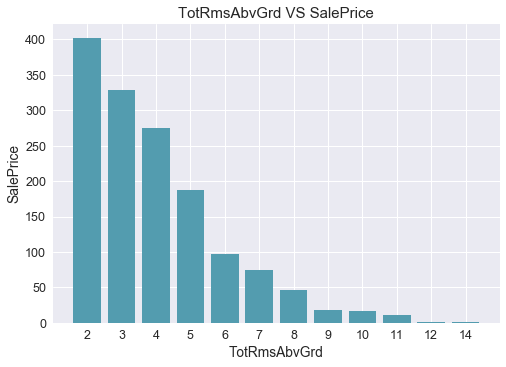

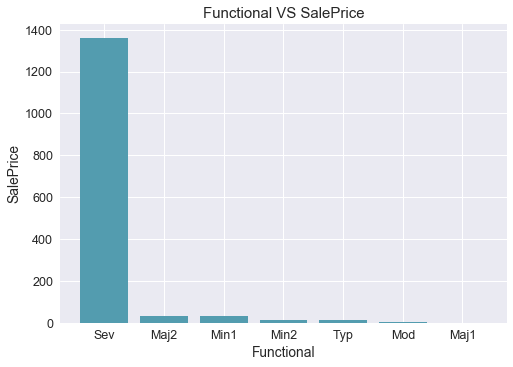

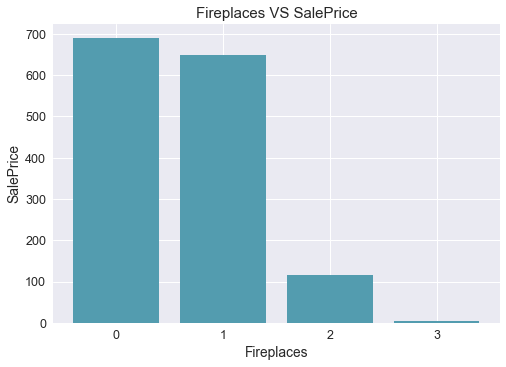

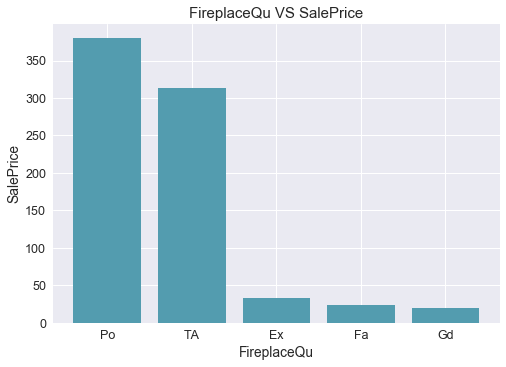

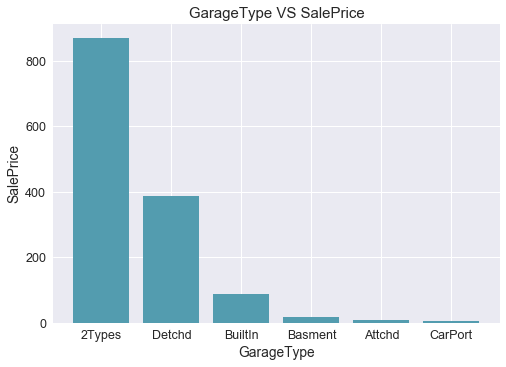

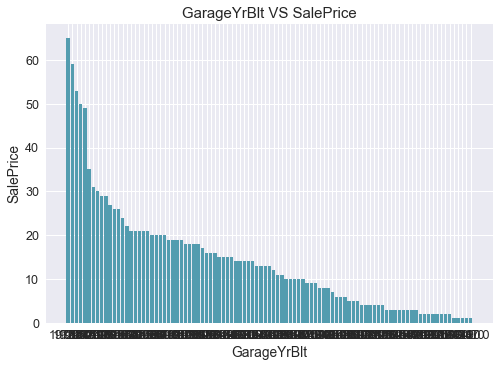

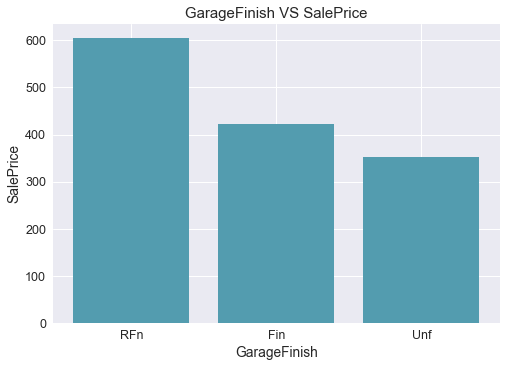

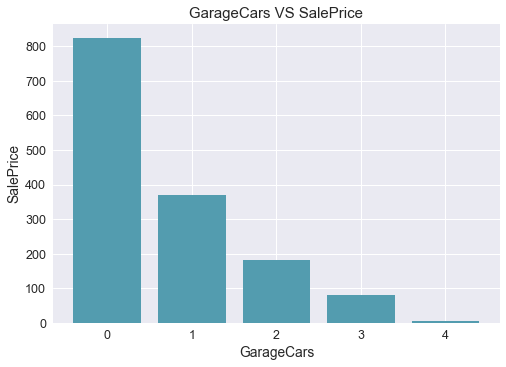

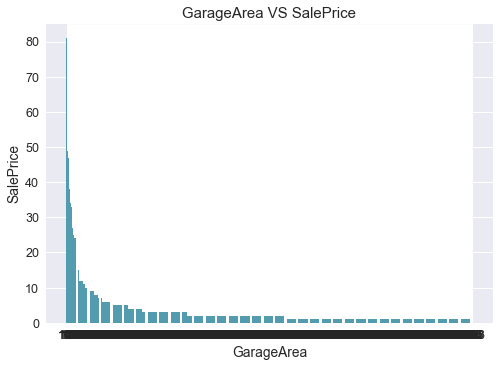

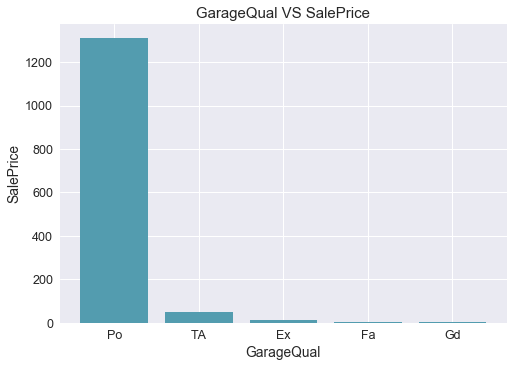

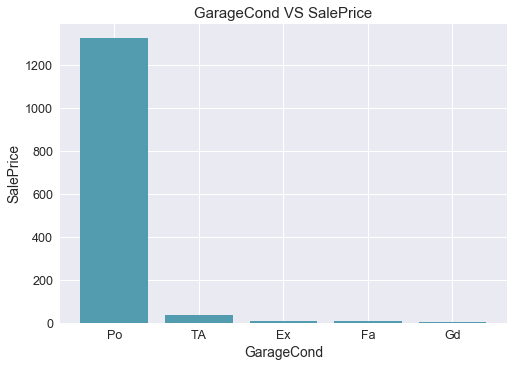

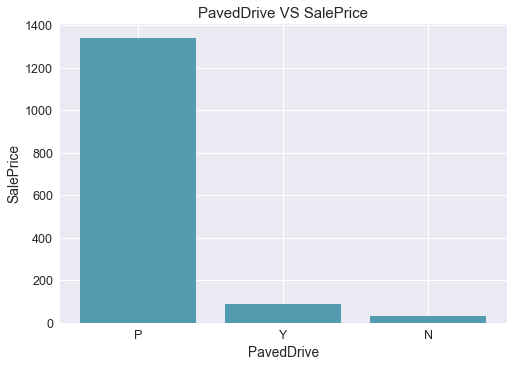

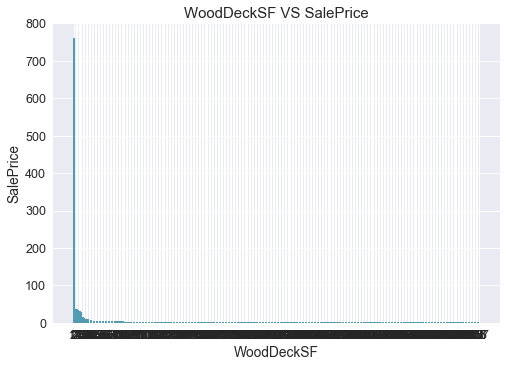

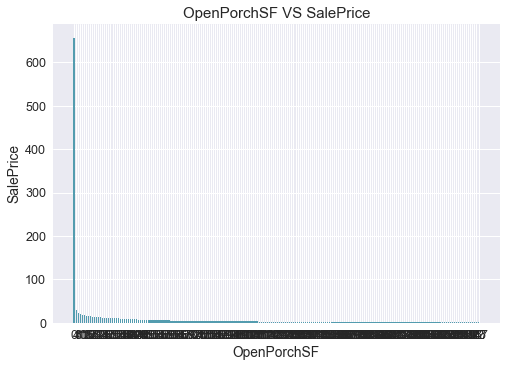

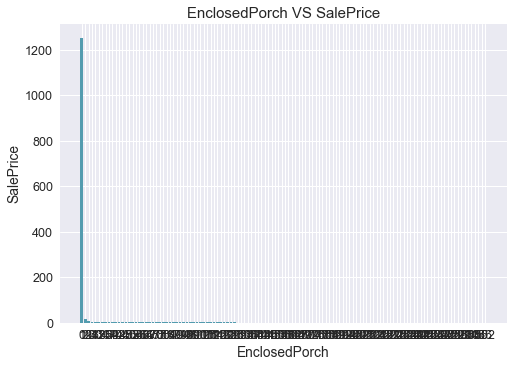

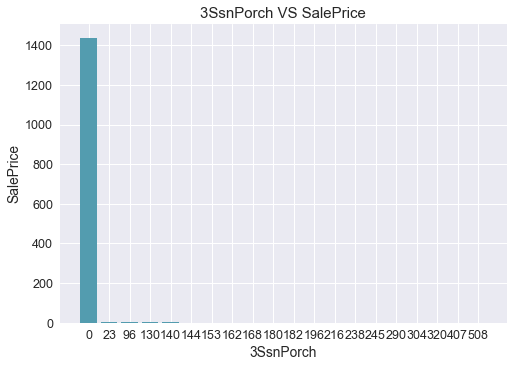

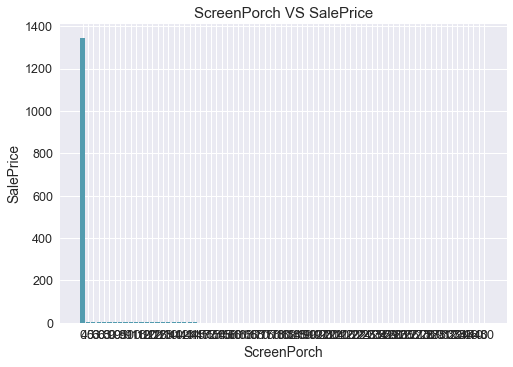

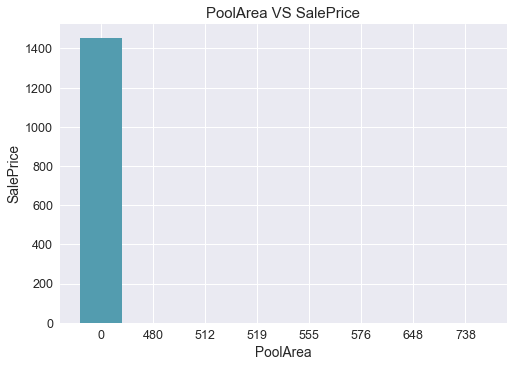

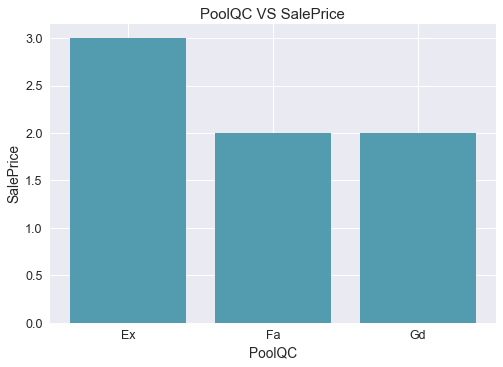

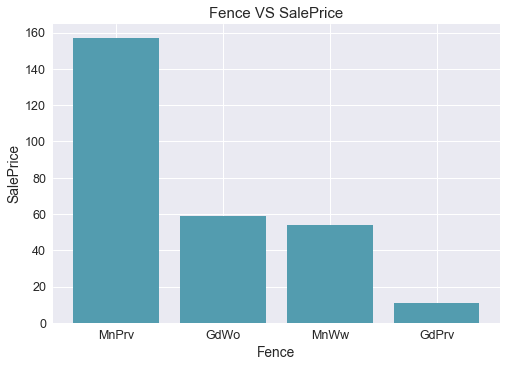

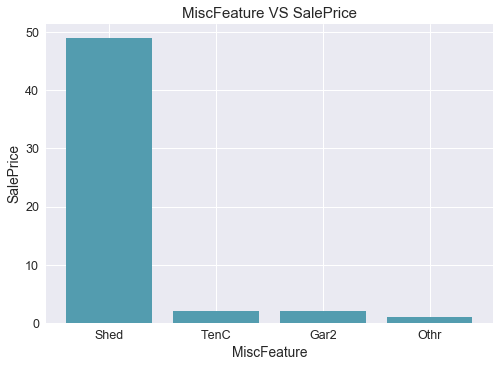

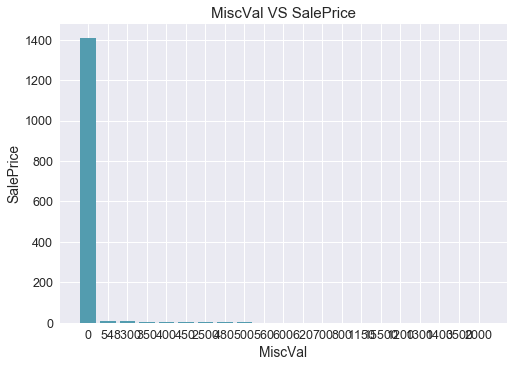

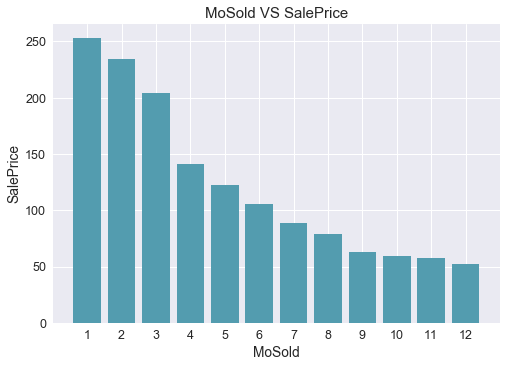

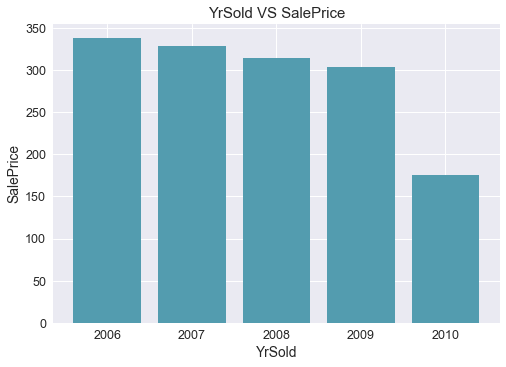

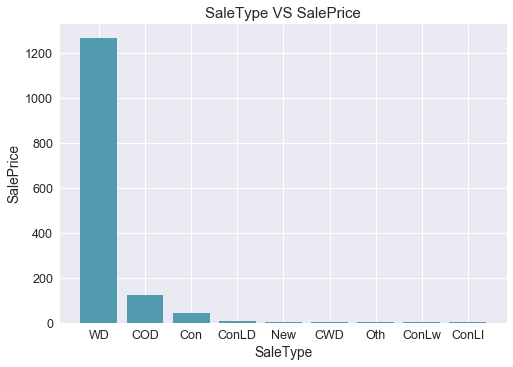

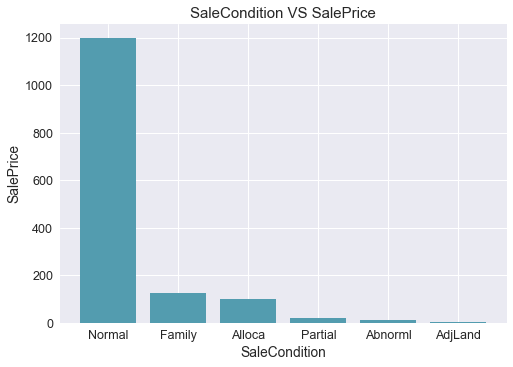

In [45]:
except_cols = ['SalePrice','Id']
for col in train.columns:
    if col not in except_cols:
        x_feature = train[col].value_counts(sort=False,ascending=True).index.values
        y =train[col].value_counts().values
        build_bar_graph(x_feature,y,col,'SalePrice',col+' VS SalePrice')

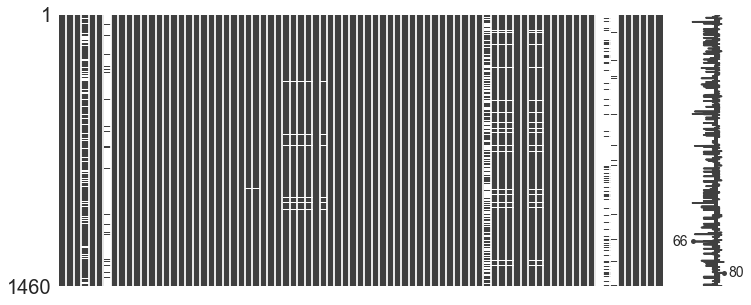

In [19]:
bulid_graph_missing_data(train)

In [20]:
missing_data_percent(train)

              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000


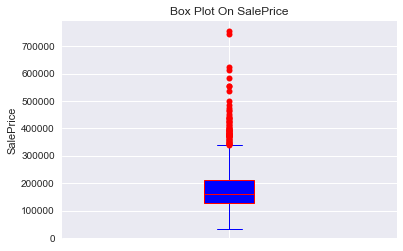

In [21]:
y_data = train['SalePrice']
x=''
x_label = ''
y_label = 'SalePrice'
title = 'Box Plot On SalePrice'
build_box_plot(x,y_data,x_label,y_label,title)

------------偏斜值/峰度------------


Skewness: 1.882876
Kurtosis: 6.536282



 mu = 180921.20 and sigma = 79415.29

Q-Q图



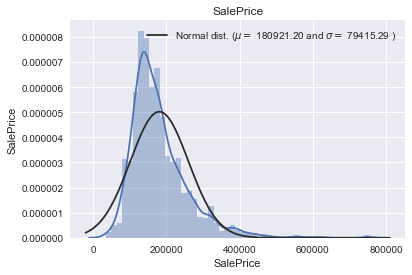

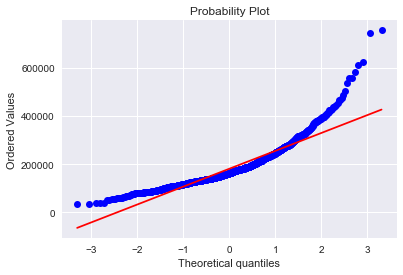

In [22]:
build_normal_graph(train,'SalePrice','SalePrice','SalePrice')

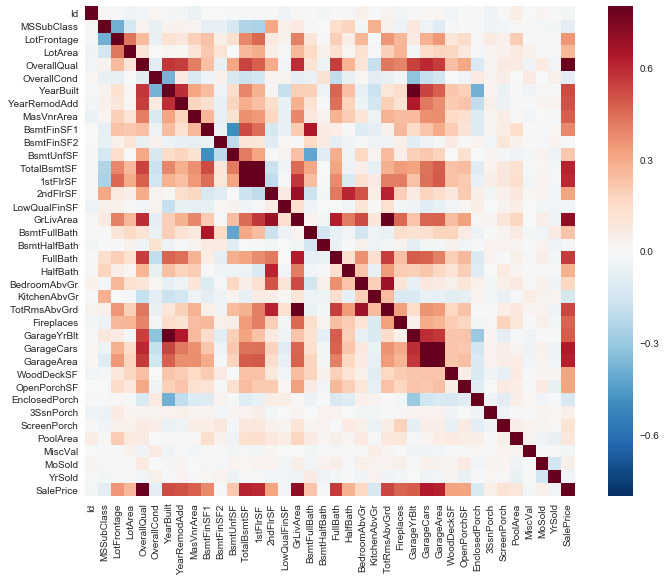

In [23]:
all_cols_heatmap_graph(train)

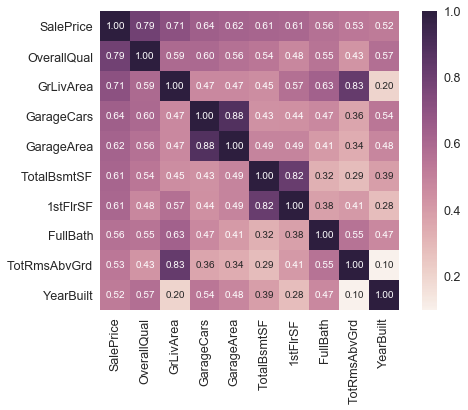

In [26]:
n_heatmap_graph(train,10)

## summary

* 1、样本量=1460 含有81列，有效属性为80
* 2、存在缺失值，有些列缺失较为严重
* 3、在每列的分布图中，我们发现大部分列是分布不均衡的数据,很大属性都集中在某个值
* 4、在箱线图中，明显发现异常值
* 5、从热力图中，我们看出变量间的相关性